In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Additional libraries for advanced analysis
import networkx as nx
from textblob import TextBlob
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


print("All packages imported successfully!")


All packages imported successfully!


In [2]:
# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

# Configuration
CONFIG = {
    'random_state': 42,
    'test_size': 0.3,
    'n_clusters': 5,
    'sample_size_for_demo': 10000,
    'fraud_rate': 0.02,  # 2% fraud rate for demo data
    'figure_size': (15, 10)
}

# Set random seed for reproducibility
np.random.seed(CONFIG['random_state'])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_or_generate_data():
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fraudTrain.csv')
    print(f"Real data loaded: {df.shape}")

    return df

# Load the data
df = load_or_generate_data()

# Basic info
print(f"\n Dataset Overview:")
print(f"   Shape: {df.shape}")
print(f"   Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"   Columns: {len(df.columns)}")
print(f"   Date range: {df['trans_date_trans_time'].min()} to {df['trans_date_trans_time'].max()}")


Real data loaded: (1296675, 23)

 Dataset Overview:
   Shape: (1296675, 23)
   Memory usage: 227.54 MB
   Columns: 23
   Date range: 2019-01-01 00:00:18 to 2020-06-21 12:13:37


In [5]:
print(df.head())

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48

In [ ]:
def analyze_data_quality(df):
    """Comprehensive data quality analysis"""
    print("DATA QUALITY ANALYSIS")
    print("="*50)

    # Basic statistics
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

    # Data types
    print(f"\n Data Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")

    # Missing values
    print(f"\n Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("  No missing values found!")

    # Unique values
    print(f"\n Unique Values per Column:")
    for col in df.columns:
        unique_count = df[col].nunique()
        unique_pct = (unique_count / len(df)) * 100
        print(f"   {col}: {unique_count:,} ({unique_pct:.1f}%)")

    # Target variable analysis
    if 'is_fraud' in df.columns:
        print(f"\n Fraud Distribution:")
        fraud_counts = df['is_fraud'].value_counts()
        fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100
        print(f"   Normal transactions: {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
        print(f"   Fraudulent transactions: {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
        print(f"   Class imbalance ratio: {fraud_counts[0]/fraud_counts[1]:.1f}:1")

    return missing_df

# Run data quality analysis
quality_report = analyze_data_quality(df)


DATA QUALITY ANALYSIS
Dataset shape: (1296675, 23)
Memory usage: 227.54 MB

 Data Types:
   object: 12 columns
   int64: 6 columns
   float64: 5 columns

 Missing Values:
  No missing values found!

 Unique Values per Column:
   Unnamed: 0: 1,296,675 (100.0%)
   trans_date_trans_time: 1,274,791 (98.3%)
   cc_num: 983 (0.1%)
   merchant: 693 (0.1%)
   category: 14 (0.0%)
   amt: 52,928 (4.1%)
   first: 352 (0.0%)
   last: 481 (0.0%)
   gender: 2 (0.0%)
   street: 983 (0.1%)
   city: 894 (0.1%)
   state: 51 (0.0%)
   zip: 970 (0.1%)
   lat: 968 (0.1%)
   long: 969 (0.1%)
   city_pop: 879 (0.1%)
   job: 494 (0.0%)
   dob: 968 (0.1%)
   trans_num: 1,296,675 (100.0%)
   unix_time: 1,274,823 (98.3%)
   merch_lat: 1,247,805 (96.2%)
   merch_long: 1,275,745 (98.4%)
   is_fraud: 2 (0.0%)

 Fraud Distribution:
   Normal transactions: 1,289,169 (99.42%)
   Fraudulent transactions: 7,506 (0.58%)
   Class imbalance ratio: 171.8:1


In [ ]:
def basic_statistical_analysis(df):
    """Basic statistical analysis and visualization"""
    print("BASIC STATISTICAL ANALYSIS")
    print("="*50)

    # Numeric columns analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'is_fraud' in numeric_cols:
        numeric_cols.remove('is_fraud')

    print(f"Numeric columns: {len(numeric_cols)}")

    # Basic statistics
    if numeric_cols:
        print(f"\n Descriptive Statistics:")
        stats = df[numeric_cols].describe()
        print(stats.round(2))

    # Correlation analysis
    if len(numeric_cols) > 1 and 'is_fraud' in df.columns:
        print(f"\n Correlation with Fraud:")
        correlations = df[numeric_cols + ['is_fraud']].corr()['is_fraud'].abs().sort_values(ascending=False)
        print("Top features correlated with fraud:")
        print(correlations.head(10).round(3))

    return stats if numeric_cols else None

# Run basic statistical analysis
stats_summary = basic_statistical_analysis(df)

BASIC STATISTICAL ANALYSIS
Numeric columns: 10

 Descriptive Statistics:
       Unnamed: 0        cc_num         amt         zip         lat  \
count  1296675.00  1.296675e+06  1296675.00  1296675.00  1296675.00   
mean    648337.00  4.171920e+17       70.35    48800.67       38.54   
std     374317.97  1.308806e+18      160.32    26893.22        5.08   
min          0.00  6.041621e+10        1.00     1257.00       20.03   
25%     324168.50  1.800429e+14        9.65    26237.00       34.62   
50%     648337.00  3.521417e+15       47.52    48174.00       39.35   
75%     972505.50  4.642255e+15       83.14    72042.00       41.94   
max    1296674.00  4.992346e+18    28948.90    99783.00       66.69   

             long    city_pop     unix_time   merch_lat  merch_long  
count  1296675.00  1296675.00  1.296675e+06  1296675.00  1296675.00  
mean       -90.23    88824.44  1.349244e+09       38.54      -90.23  
std         13.76   301956.36  1.284128e+07        5.11       13.77  
min    

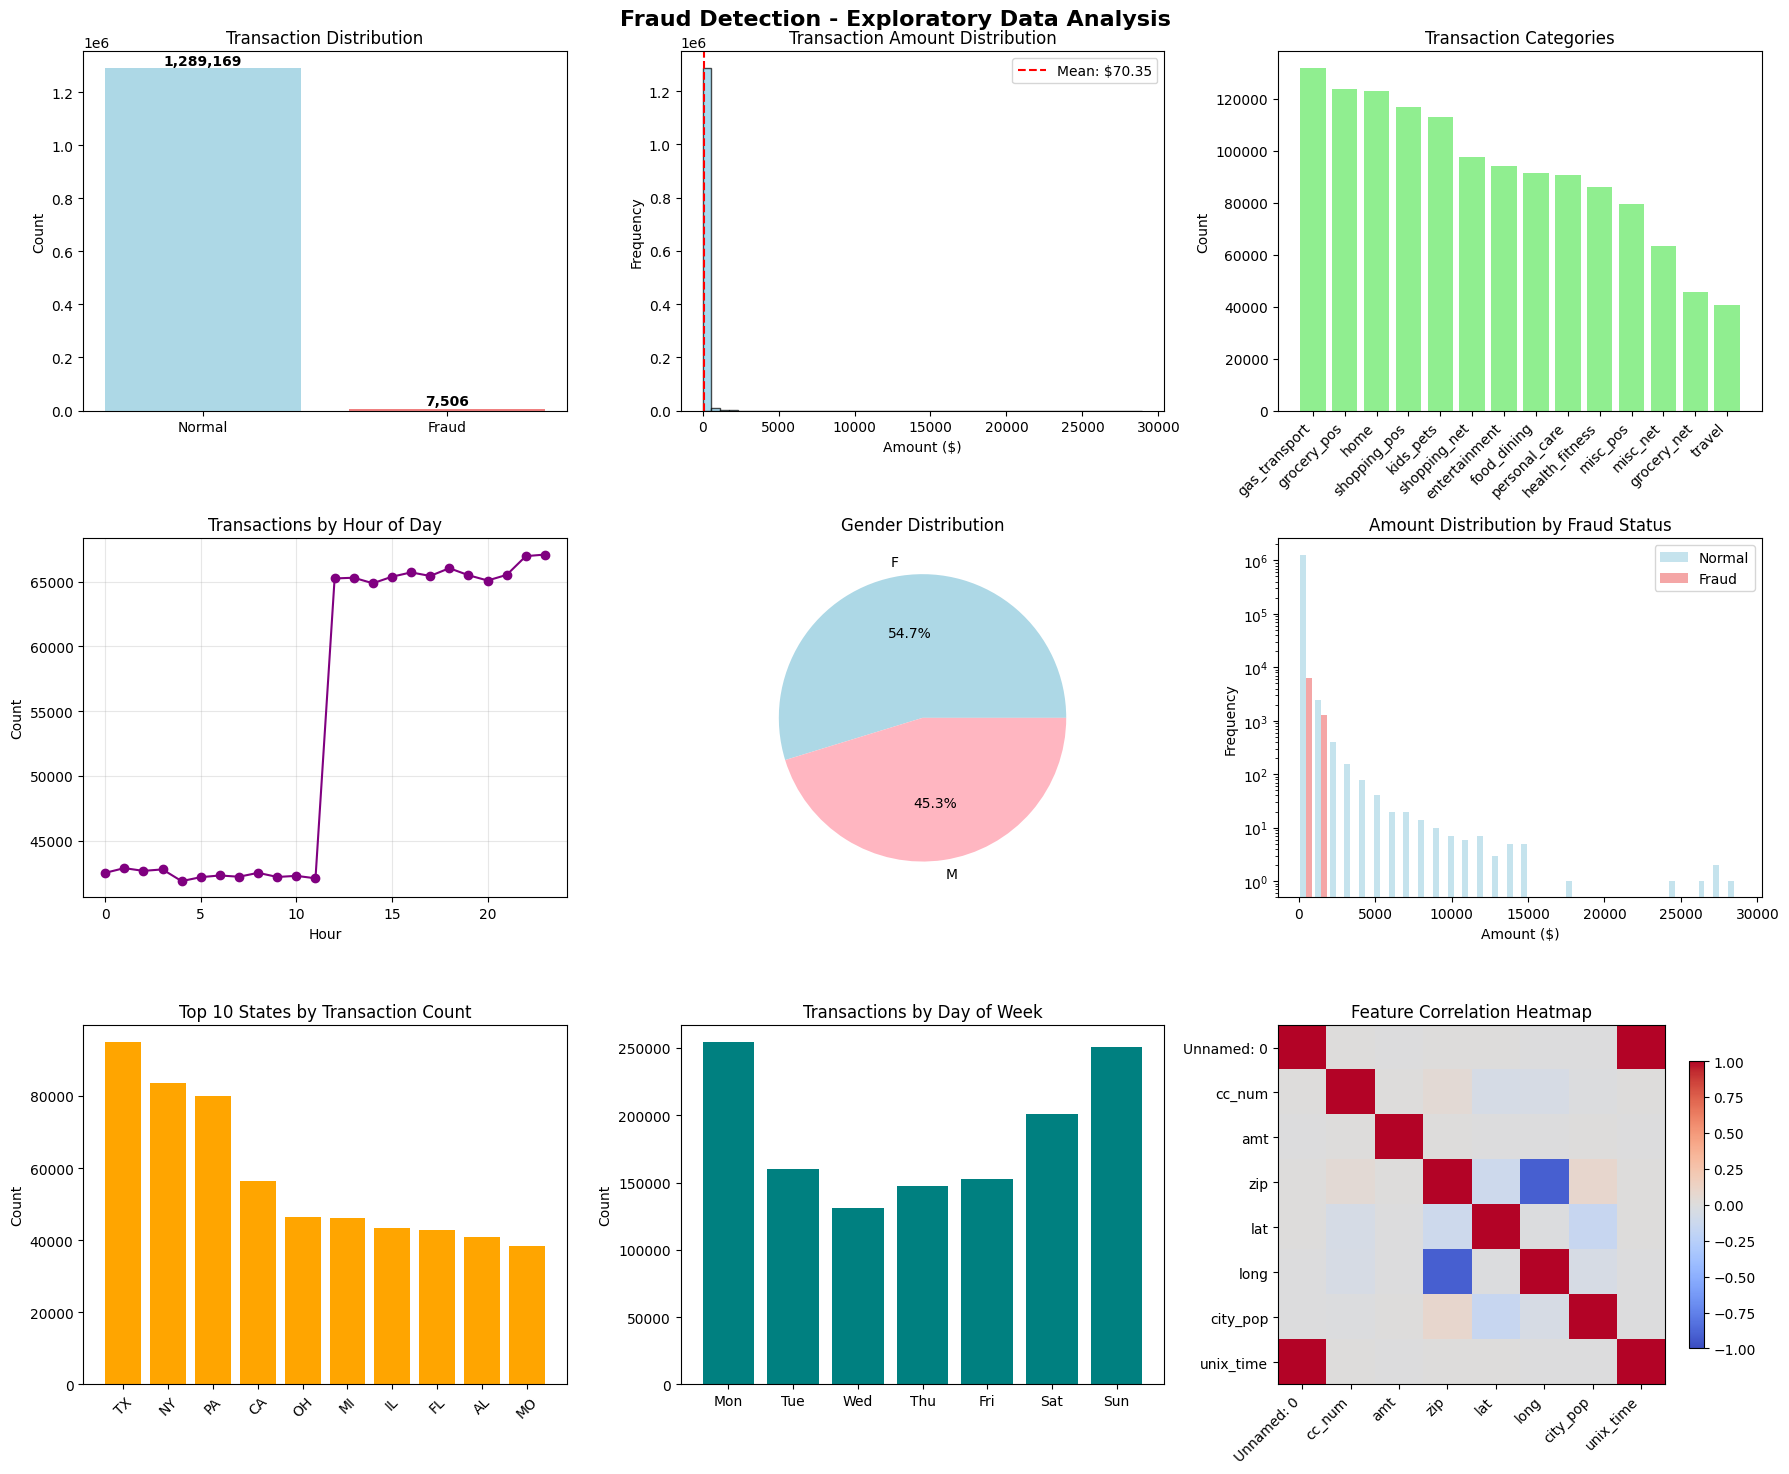

In [ ]:
def create_basic_visualizations(df):
    """Create basic exploratory visualizations"""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Fraud Detection - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # 1. Fraud distribution
    if 'is_fraud' in df.columns:
        fraud_counts = df['is_fraud'].value_counts()
        axes[0,0].bar(['Normal', 'Fraud'], fraud_counts.values, color=['lightblue', 'lightcoral'])
        axes[0,0].set_title('Transaction Distribution')
        axes[0,0].set_ylabel('Count')
        for i, v in enumerate(fraud_counts.values):
            axes[0,0].text(i, v + max(fraud_counts.values)*0.01, f'{v:,}', ha='center', fontweight='bold')

    # 2. Amount distribution
    if 'amt' in df.columns:
        axes[0,1].hist(df['amt'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,1].set_title('Transaction Amount Distribution')
        axes[0,1].set_xlabel('Amount ($)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(df['amt'].mean(), color='red', linestyle='--', label=f'Mean: ${df["amt"].mean():.2f}')
        axes[0,1].legend()

    # 3. Category distribution
    if 'category' in df.columns:
        category_counts = df['category'].value_counts()
        axes[0,2].bar(range(len(category_counts)), category_counts.values, color='lightgreen')
        axes[0,2].set_title('Transaction Categories')
        axes[0,2].set_xticks(range(len(category_counts)))
        axes[0,2].set_xticklabels(category_counts.index, rotation=45, ha='right')
        axes[0,2].set_ylabel('Count')

    # 4. Hourly distribution
    if 'trans_date_trans_time' in df.columns:
        df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        axes[1,0].plot(hourly_counts.index, hourly_counts.values, marker='o', color='purple')
        axes[1,0].set_title('Transactions by Hour of Day')
        axes[1,0].set_xlabel('Hour')
        axes[1,0].set_ylabel('Count')
        axes[1,0].grid(True, alpha=0.3)

    # 5. Gender distribution
    if 'gender' in df.columns:
        gender_counts = df['gender'].value_counts()
        axes[1,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                     colors=['lightblue', 'lightpink'])
        axes[1,1].set_title('Gender Distribution')

    # 6. Fraud by amount (if fraud column exists)
    if 'is_fraud' in df.columns and 'amt' in df.columns:
        fraud_data = df[df['is_fraud'] == 1]['amt']
        normal_data = df[df['is_fraud'] == 0]['amt']
        axes[1,2].hist([normal_data, fraud_data], bins=30, alpha=0.7,
                      label=['Normal', 'Fraud'], color=['lightblue', 'lightcoral'])
        axes[1,2].set_title('Amount Distribution by Fraud Status')
        axes[1,2].set_xlabel('Amount ($)')
        axes[1,2].set_ylabel('Frequency')
        axes[1,2].legend()
        axes[1,2].set_yscale('log')

    # 7. State distribution (top 10)
    if 'state' in df.columns:
        state_counts = df['state'].value_counts().head(10)
        axes[2,0].bar(range(len(state_counts)), state_counts.values, color='orange')
        axes[2,0].set_title('Top 10 States by Transaction Count')
        axes[2,0].set_xticks(range(len(state_counts)))
        axes[2,0].set_xticklabels(state_counts.index, rotation=45)
        axes[2,0].set_ylabel('Count')

    # 8. Day of week analysis
    if 'trans_date_trans_time' in df.columns:
        df['day_of_week'] = pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        daily_counts = df['day_of_week'].value_counts().sort_index()
        axes[2,1].bar(range(7), daily_counts.values, color='teal')
        axes[2,1].set_title('Transactions by Day of Week')
        axes[2,1].set_xticks(range(7))
        axes[2,1].set_xticklabels(day_names)
        axes[2,1].set_ylabel('Count')

    # 9. Correlation heatmap
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 2:
        # Select a subset of numeric columns for better visualization
        corr_cols = numeric_cols[:8] if len(numeric_cols) > 8 else numeric_cols
        corr_matrix = df[corr_cols].corr()
        im = axes[2,2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[2,2].set_title('Feature Correlation Heatmap')
        axes[2,2].set_xticks(range(len(corr_cols)))
        axes[2,2].set_yticks(range(len(corr_cols)))
        axes[2,2].set_xticklabels(corr_cols, rotation=45, ha='right')
        axes[2,2].set_yticklabels(corr_cols)
        plt.colorbar(im, ax=axes[2,2], shrink=0.8)

    plt.tight_layout()
    plt.show()

# Create visualizations
create_basic_visualizations(df)

TEMPORAL PATTERN ANALYSIS
Peak fraud hour: 22:00 (rate: 0.0288)
Peak fraud day: Friday (rate: 0.0071)


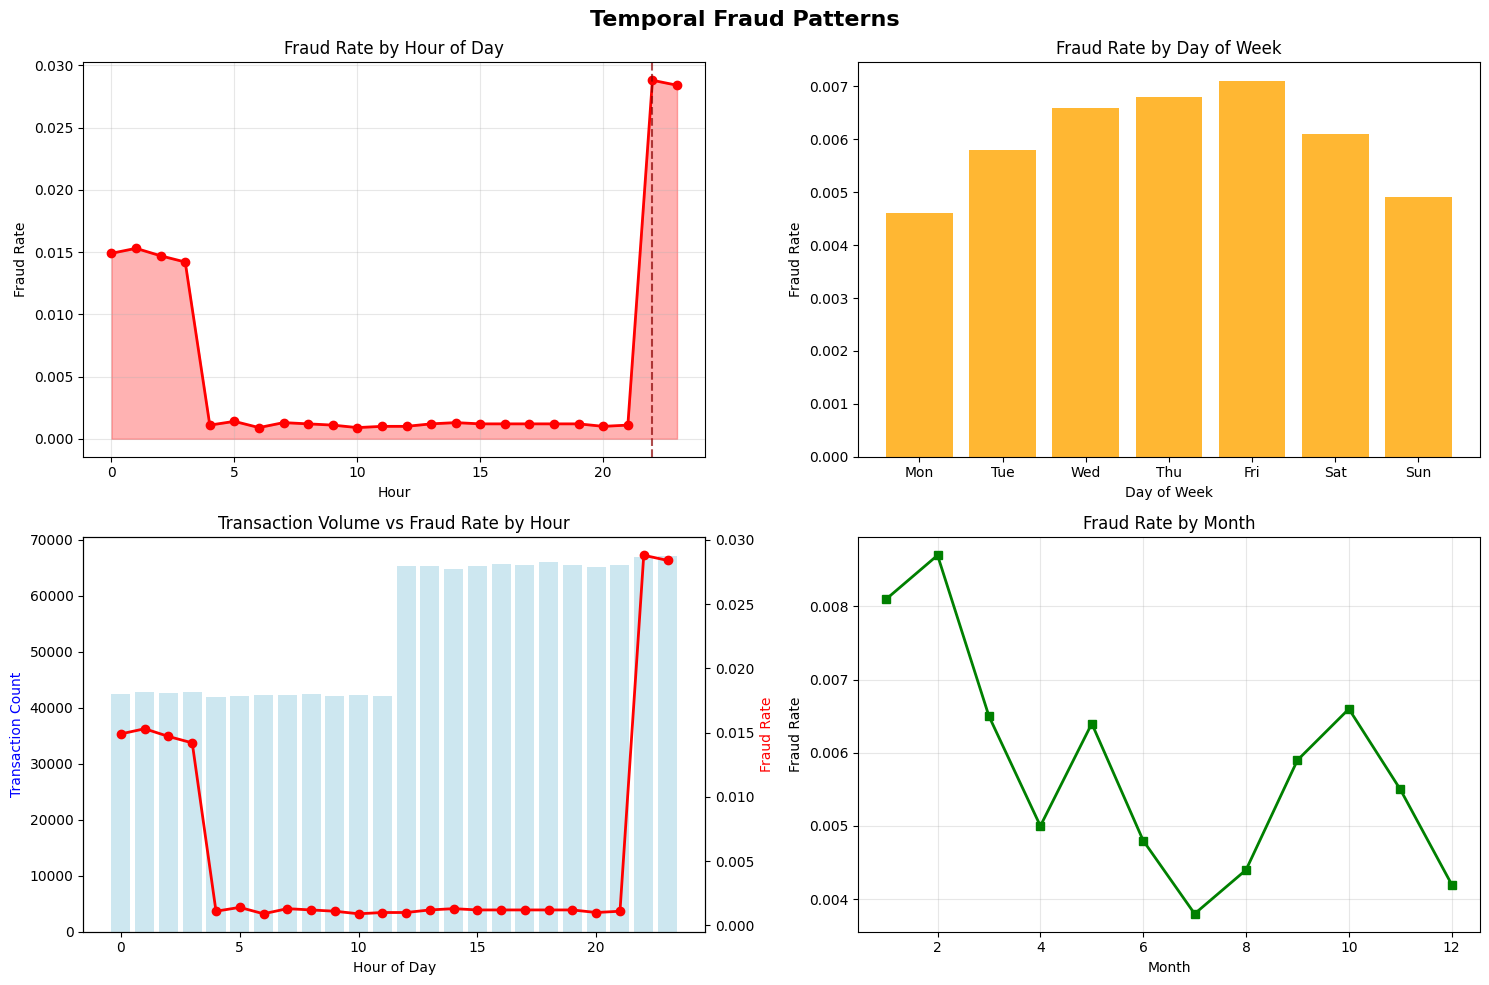

In [ ]:
def analyze_temporal_patterns(df):
    """Analyze temporal patterns in transactions and fraud"""
    print("TEMPORAL PATTERN ANALYSIS")
    print("="*50)

    if 'trans_date_trans_time' not in df.columns:
        print("No datetime column found")
        return

    # Convert to datetime
    df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_datetime'].dt.hour
    df['day_of_week'] = df['trans_datetime'].dt.dayofweek
    df['month'] = df['trans_datetime'].dt.month
    df['day_of_month'] = df['trans_datetime'].dt.day

    if 'is_fraud' in df.columns:
        # Hourly fraud analysis
        hourly_fraud = df.groupby('hour')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
        peak_fraud_hour = hourly_fraud['mean'].idxmax()
        print(f"Peak fraud hour: {peak_fraud_hour}:00 (rate: {hourly_fraud.loc[peak_fraud_hour, 'mean']:.4f})")

        # Daily fraud analysis
        daily_fraud = df.groupby('day_of_week')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        peak_fraud_day = daily_fraud['mean'].idxmax()
        print(f"Peak fraud day: {day_names[peak_fraud_day]} (rate: {daily_fraud.loc[peak_fraud_day, 'mean']:.4f})")

        # Visualize temporal patterns
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Temporal Fraud Patterns', fontsize=16, fontweight='bold')

        # Hourly fraud rate
        axes[0,0].plot(hourly_fraud.index, hourly_fraud['mean'], marker='o', color='red', linewidth=2)
        axes[0,0].fill_between(hourly_fraud.index, hourly_fraud['mean'], alpha=0.3, color='red')
        axes[0,0].set_title('Fraud Rate by Hour of Day')
        axes[0,0].set_xlabel('Hour')
        axes[0,0].set_ylabel('Fraud Rate')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].axvline(peak_fraud_hour, color='darkred', linestyle='--', alpha=0.7)

        # Daily fraud rate
        axes[0,1].bar(range(7), daily_fraud['mean'], color='orange', alpha=0.8)
        axes[0,1].set_title('Fraud Rate by Day of Week')
        axes[0,1].set_xlabel('Day of Week')
        axes[0,1].set_ylabel('Fraud Rate')
        axes[0,1].set_xticks(range(7))
        axes[0,1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

        # Transaction volume vs fraud rate by hour
        ax2 = axes[1,0].twinx()
        bars = axes[1,0].bar(hourly_fraud.index, hourly_fraud['count'], alpha=0.6, color='lightblue')
        line = ax2.plot(hourly_fraud.index, hourly_fraud['mean'], color='red', marker='o', linewidth=2)
        axes[1,0].set_xlabel('Hour of Day')
        axes[1,0].set_ylabel('Transaction Count', color='blue')
        ax2.set_ylabel('Fraud Rate', color='red')
        axes[1,0].set_title('Transaction Volume vs Fraud Rate by Hour')

        # Monthly analysis if data spans multiple months
        if df['month'].nunique() > 1:
            monthly_fraud = df.groupby('month')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
            axes[1,1].plot(monthly_fraud.index, monthly_fraud['mean'], marker='s', color='green', linewidth=2)
            axes[1,1].set_title('Fraud Rate by Month')
            axes[1,1].set_xlabel('Month')
            axes[1,1].set_ylabel('Fraud Rate')
            axes[1,1].grid(True, alpha=0.3)
        else:
            # Day of month analysis instead
            daily_month_fraud = df.groupby('day_of_month')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
            axes[1,1].plot(daily_month_fraud.index, daily_month_fraud['mean'], marker='s', color='green', linewidth=2)
            axes[1,1].set_title('Fraud Rate by Day of Month')
            axes[1,1].set_xlabel('Day of Month')
            axes[1,1].set_ylabel('Fraud Rate')
            axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return {
            'peak_fraud_hour': peak_fraud_hour,
            'peak_fraud_day': day_names[peak_fraud_day],
            'hourly_stats': hourly_fraud,
            'daily_stats': daily_fraud
        }

# Run temporal analysis
temporal_results = analyze_temporal_patterns(df)

In [15]:
def enhanced_temporal_analysis(df):
    """Enhanced temporal analysis with period comparisons and advanced patterns"""
    print("ENHANCED TEMPORAL ANALYSIS")
    print("="*50)

    # Identify datetime columns
    datetime_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

    if not datetime_cols:
        print("No datetime columns found")
        return

    # Convert to datetime
    datetime_col = datetime_cols[0]
    df['transaction_datetime'] = pd.to_datetime(df[datetime_col])

    # Extract comprehensive temporal features
    df['year'] = df['transaction_datetime'].dt.year
    df['month'] = df['transaction_datetime'].dt.month
    df['day'] = df['transaction_datetime'].dt.day
    df['hour'] = df['transaction_datetime'].dt.hour
    df['minute'] = df['transaction_datetime'].dt.minute
    df['day_of_week'] = df['transaction_datetime'].dt.dayofweek  # Monday=0, Sunday=6
    df['day_name'] = df['transaction_datetime'].dt.day_name()
    df['week_of_year'] = df['transaction_datetime'].dt.isocalendar().week
    df['quarter'] = df['transaction_datetime'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['time_of_day'] = pd.cut(df['hour'],
                              bins=[0, 6, 12, 18, 24],
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                              right=False)

    # Time period analysis
    print("\nTIME PERIOD ANALYSIS:")
    print("-"*40)

    # 1. Daily patterns
    daily_patterns = df.groupby('day_name')['is_fraud'].agg(['count', 'mean', 'sum'])
    daily_patterns = daily_patterns.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    print("\nDaily Patterns:")
    print(daily_patterns.round(4))

    # 2. Hourly patterns
    hourly_patterns = df.groupby('hour')['is_fraud'].agg(['count', 'mean', 'sum'])
    print("\nHourly Patterns:")
    print(hourly_patterns.round(4))

    # 3. Time of day patterns
    time_of_day_patterns = df.groupby('time_of_day')['is_fraud'].agg(['count', 'mean', 'sum'])
    print("\nTime of Day Patterns:")
    print(time_of_day_patterns.round(4))

    # 4. Weekend vs weekday
    weekend_patterns = df.groupby('is_weekend')['is_fraud'].agg(['count', 'mean', 'sum'])
    weekend_patterns.index = weekend_patterns.index.map({0: 'Weekday', 1: 'Weekend'})
    print("\nWeekend vs Weekday Patterns:")
    print(weekend_patterns.round(4))

    # 5. Monthly/seasonal patterns
    monthly_patterns = df.groupby('month')['is_fraud'].agg(['count', 'mean', 'sum'])
    print("\nMonthly Patterns:")
    print(monthly_patterns.round(4))

    # 6. Yearly patterns (if data spans multiple years)
    if df['year'].nunique() > 1:
        yearly_patterns = df.groupby('year')['is_fraud'].agg(['count', 'mean', 'sum'])
        print("\nYearly Patterns:")
        print(yearly_patterns.round(4))

    # Create comparison visualizations
    fig = make_subplots(rows=2, cols=2,
                       subplot_titles=('Fraud Rate by Day of Week',
                                      'Fraud Rate by Hour',
                                      'Fraud Rate by Time of Day',
                                      'Monthly Fraud Patterns'))

    # 1. Day of week
    fig.add_trace(
        go.Bar(x=daily_patterns.index,
               y=daily_patterns['mean'],
               marker_color='skyblue',
               name='Fraud Rate'),
        row=1, col=1
    )

    # 2. Hourly patterns
    fig.add_trace(
        go.Scatter(x=hourly_patterns.index,
                  y=hourly_patterns['mean'],
                  mode='lines+markers',
                  line_color='coral',
                  name='Fraud Rate'),
        row=1, col=2
    )

    # 3. Time of day
    fig.add_trace(
        go.Bar(x=time_of_day_patterns.index,
               y=time_of_day_patterns['mean'],
               marker_color='lightgreen',
               name='Fraud Rate'),
        row=2, col=1
    )

    # 4. Monthly patterns
    fig.add_trace(
        go.Scatter(x=monthly_patterns.index,
                  y=monthly_patterns['mean'],
                  mode='lines+markers',
                  line_color='purple',
                  name='Fraud Rate'),
        row=2, col=2
    )

    fig.update_layout(
        height=1200,
        width=1200,
        title_text="Comprehensive Temporal Fraud Patterns",
        showlegend=False,
        template='plotly_white'
    )

    fig.show()

    # Advanced time-based features
    print("\nCREATING ADVANCED TIME-BASED FEATURES:")
    print("-"*40)

    # Time since last transaction (per card)
    if 'cc_num' in df.columns:
        df = df.sort_values(['cc_num', 'transaction_datetime'])
        df['time_since_last_txn'] = df.groupby('cc_num')['transaction_datetime'].diff().dt.total_seconds() / 60  # in minutes

        # Analyze time between transactions for fraud vs non-fraud
        time_between_stats = df.groupby('is_fraud')['time_since_last_txn'].agg(['mean', 'median', 'std'])
        print("\nTime Between Transactions (minutes):")
        print(time_between_stats.round(2))

    # Time of day risk score (custom metric)
    hourly_risk = hourly_patterns['mean'] / hourly_patterns['mean'].mean()
    df['hourly_risk_score'] = df['hour'].map(hourly_risk)

    # Day of week risk score
    daily_risk = daily_patterns['mean'] / daily_patterns['mean'].mean()
    df['daily_risk_score'] = df['day_name'].map(daily_risk)

    # Combined temporal risk score
    df['temporal_risk_score'] = df['hourly_risk_score'] * df['daily_risk_score']

    print("\nSample of created temporal risk features:")
    print(df[['hour', 'day_name', 'hourly_risk_score', 'daily_risk_score', 'temporal_risk_score']].head())

    # Return key patterns and modified dataframe
    return {
        'daily_patterns': daily_patterns,
        'hourly_patterns': hourly_patterns,
        'time_of_day_patterns': time_of_day_patterns,
        'weekend_patterns': weekend_patterns,
        'monthly_patterns': monthly_patterns,
        'enhanced_df': df
    }


enhanced_temp_results = enhanced_temporal_analysis(df)

ENHANCED TEMPORAL ANALYSIS

TIME PERIOD ANALYSIS:
----------------------------------------

Daily Patterns:
            count    mean   sum
day_name                       
Monday     254282  0.0046  1182
Tuesday    160227  0.0058   935
Wednesday  131073  0.0066   859
Thursday   147285  0.0068  1008
Friday     152272  0.0071  1079
Saturday   200957  0.0061  1227
Sunday     250579  0.0049  1216

Hourly Patterns:
      count    mean   sum
hour                     
0     42502  0.0149   635
1     42869  0.0153   658
2     42656  0.0147   625
3     42769  0.0142   609
4     41863  0.0011    46
5     42171  0.0014    60
6     42300  0.0009    40
7     42203  0.0013    56
8     42505  0.0012    49
9     42185  0.0011    47
10    42271  0.0009    40
11    42082  0.0010    42
12    65257  0.0010    67
13    65314  0.0012    80
14    64885  0.0013    86
15    65391  0.0012    79
16    65726  0.0012    76
17    65450  0.0012    78
18    66051  0.0012    81
19    65508  0.0012    81
20    65098  0


CREATING ADVANCED TIME-BASED FEATURES:
----------------------------------------

Time Between Transactions (minutes):
            mean  median     std
is_fraud                        
0         542.49  277.05  790.82
1         355.39   81.80  607.28

Sample of created temporal risk features:
      hour   day_name  hourly_risk_score  daily_risk_score  \
1017    12    Tuesday           0.179774          0.974298   
2724     8  Wednesday           0.201853          1.094198   
2726     8  Wednesday           0.201853          1.094198   
2882    12  Wednesday           0.179774          1.094198   
2907    13  Wednesday           0.214469          1.094198   

      temporal_risk_score  
1017             0.175154  
2724             0.220868  
2726             0.220868  
2882             0.196709  
2907             0.234671  


ANOMALY DETECTION
Statistical Outlier Detection (IQR Method):
   Unnamed: 0: 0 outliers (0.00%)
   cc_num: 118,789 outliers (9.16%)
   amt: 67,290 outliers (5.19%)
   zip: 0 outliers (0.00%)
   lat: 4,679 outliers (0.36%)

 Isolation Forest Anomaly Detection:
   Detected 64,834 anomalies (5.00%)
   Fraud rate in anomalies: 0.0530
   Overall fraud rate: 0.0058
   Anomaly detection lift: 9.16x


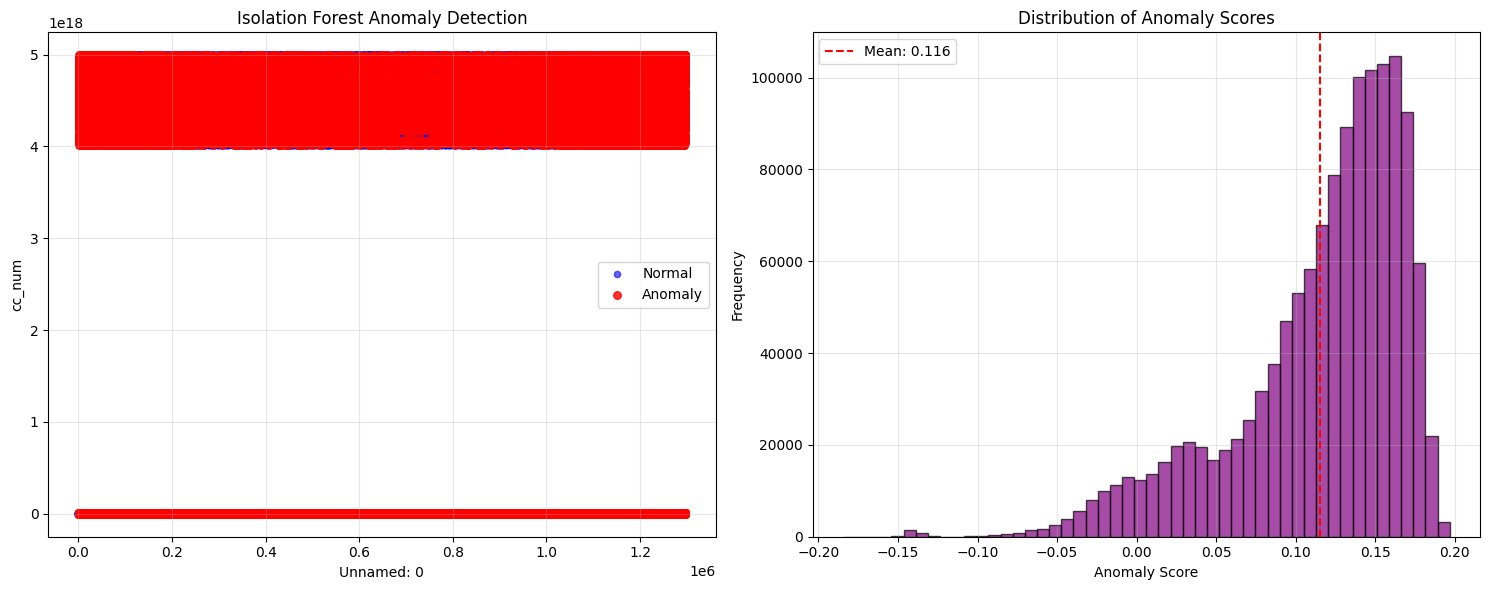

In [ ]:
def detect_anomalies(df):
    """Detect anomalies using multiple methods"""
    print("ANOMALY DETECTION")
    print("="*50)

    # Prepare numeric data
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'is_fraud' in numeric_cols:
        numeric_cols.remove('is_fraud')

    if len(numeric_cols) < 2:
        print("Insufficient numeric columns for anomaly detection")
        return

    # Statistical outliers (IQR method)
    print("Statistical Outlier Detection (IQR Method):")
    outliers_info = {}

    for col in numeric_cols[:5]:  # Limit to first 5 columns for demo
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_info[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(df) * 100
        }

        print(f"   {col}: {len(outliers):,} outliers ({len(outliers)/len(df)*100:.2f}%)")

    # Isolation Forest
    print(f"\n Isolation Forest Anomaly Detection:")
    # Use a subset of features for performance
    feature_subset = numeric_cols[:6] if len(numeric_cols) > 6 else numeric_cols
    X_anomaly = df[feature_subset].fillna(0)

    iso_forest = IsolationForest(contamination=0.05, random_state=CONFIG['random_state'])
    anomaly_labels = iso_forest.fit_predict(X_anomaly)

    df['isolation_anomaly'] = anomaly_labels
    anomaly_count = (anomaly_labels == -1).sum()
    print(f"   Detected {anomaly_count:,} anomalies ({anomaly_count/len(df)*100:.2f}%)")

    # Analyze relationship between anomalies and fraud
    if 'is_fraud' in df.columns:
        fraud_in_anomalies = df[(df['isolation_anomaly'] == -1) & (df['is_fraud'] == 1)]
        total_anomalies = (df['isolation_anomaly'] == -1).sum()
        if total_anomalies > 0:
            fraud_rate_in_anomalies = len(fraud_in_anomalies) / total_anomalies
            overall_fraud_rate = df['is_fraud'].mean()
            print(f"   Fraud rate in anomalies: {fraud_rate_in_anomalies:.4f}")
            print(f"   Overall fraud rate: {overall_fraud_rate:.4f}")
            print(f"   Anomaly detection lift: {fraud_rate_in_anomalies/overall_fraud_rate:.2f}x")

    # Visualize anomalies
    if len(feature_subset) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # 2D visualization of anomalies
        col1, col2 = feature_subset[0], feature_subset[1]
        normal_mask = df['isolation_anomaly'] == 1
        anomaly_mask = df['isolation_anomaly'] == -1

        axes[0].scatter(df.loc[normal_mask, col1], df.loc[normal_mask, col2],
                       c='blue', alpha=0.6, label='Normal', s=20)
        axes[0].scatter(df.loc[anomaly_mask, col1], df.loc[anomaly_mask, col2],
                       c='red', alpha=0.8, label='Anomaly', s=30)
        axes[0].set_xlabel(col1)
        axes[0].set_ylabel(col2)
        axes[0].set_title('Isolation Forest Anomaly Detection')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Anomaly scores distribution
        anomaly_scores = iso_forest.decision_function(X_anomaly)
        axes[1].hist(anomaly_scores, bins=50, alpha=0.7, color='purple', edgecolor='black')
        axes[1].axvline(anomaly_scores.mean(), color='red', linestyle='--',
                       label=f'Mean: {anomaly_scores.mean():.3f}')
        axes[1].set_xlabel('Anomaly Score')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of Anomaly Scores')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        'statistical_outliers': outliers_info,
        'isolation_forest_anomalies': anomaly_count,
        'anomaly_fraud_lift': fraud_rate_in_anomalies/overall_fraud_rate if 'is_fraud' in df.columns and total_anomalies > 0 else None
    }

# Run anomaly detection
anomaly_results = detect_anomalies(df)

CLUSTERING ANALYSIS
Using features for clustering: ['amt', 'lat', 'long', 'city_pop']

 K-Means Clustering (k=5):

   Cluster 0:
     Size: 637,835 (49.2%)
     Fraud rate: 0.0031
     Avg amount: $61.46

   Cluster 1:
     Size: 380,367 (29.3%)
     Fraud rate: 0.0030
     Avg amount: $61.18

   Cluster 2:
     Size: 228,727 (17.6%)
     Fraud rate: 0.0034
     Avg amount: $62.09

   Cluster 3:
     Size: 39,711 (3.1%)
     Fraud rate: 0.0042
     Avg amount: $66.03

   Cluster 4:
     Size: 10,035 (0.8%)
     Fraud rate: 0.3450
     Avg amount: $1188.23


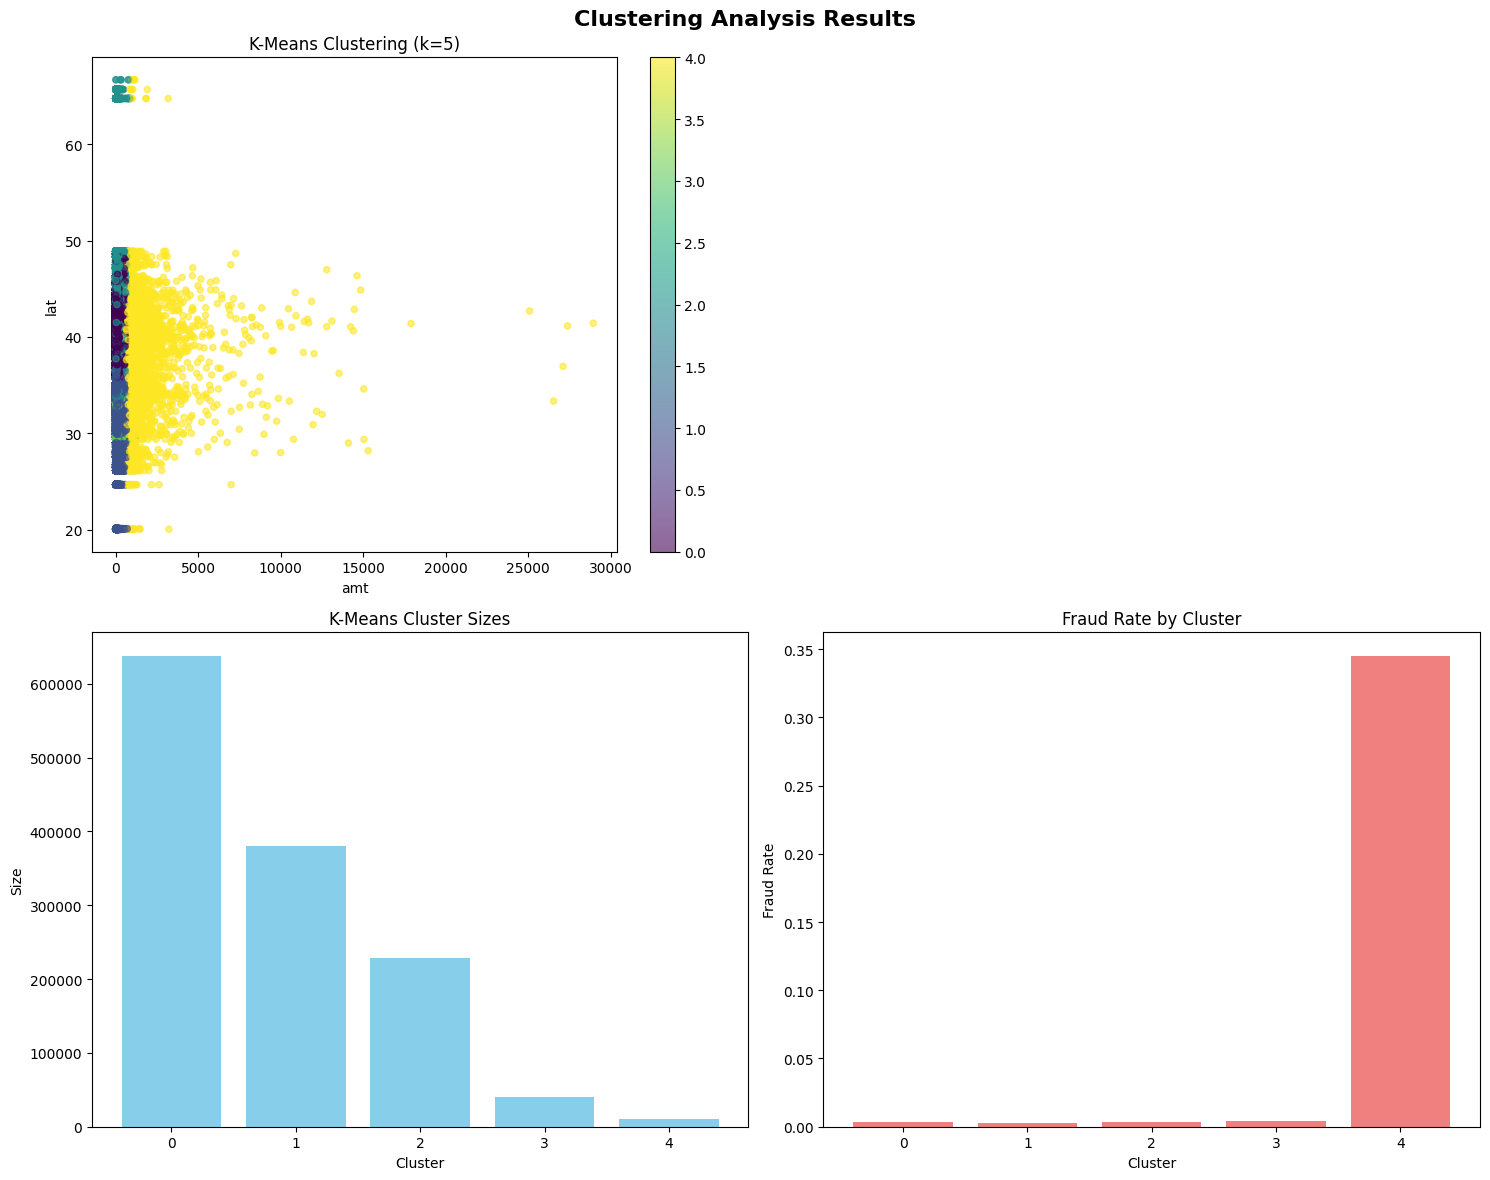

In [ ]:
def perform_clustering_analysis(df):
    """Perform clustering analysis to identify customer segments"""
    print("CLUSTERING ANALYSIS")
    print("="*50)

    # Prepare features for clustering
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'is_fraud' in numeric_cols:
        numeric_cols.remove('is_fraud')

    # Select relevant features for clustering
    clustering_features = []
    for col in ['amt', 'lat', 'long', 'city_pop', 'hour']:
        if col in df.columns:
            clustering_features.append(col)

    if len(clustering_features) < 2:
        print("Insufficient features for clustering")
        return

    print(f"Using features for clustering: {clustering_features}")

    # Prepare and scale data
    X_cluster = df[clustering_features].fillna(df[clustering_features].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    # K-Means clustering
    print(f"\n K-Means Clustering (k={CONFIG['n_clusters']}):")
    kmeans = KMeans(n_clusters=CONFIG['n_clusters'], random_state=CONFIG['random_state'])
    cluster_labels = kmeans.fit_predict(X_scaled)
    df['cluster'] = cluster_labels

    # Analyze clusters
    cluster_analysis = {}
    for i in range(CONFIG['n_clusters']):
        cluster_data = df[df['cluster'] == i]
        cluster_analysis[i] = {
            'size': len(cluster_data),
            'fraud_rate': cluster_data['is_fraud'].mean() if 'is_fraud' in df.columns else 0,
            'avg_amount': cluster_data['amt'].mean() if 'amt' in df.columns else 0,
            'characteristics': {}
        }

        # Analyze characteristics of each cluster
        for col in clustering_features:
            cluster_analysis[i]['characteristics'][col] = {
                'mean': cluster_data[col].mean(),
                'std': cluster_data[col].std()
            }

    # Print cluster insights
    for i, analysis in cluster_analysis.items():
        print(f"\n   Cluster {i}:")
        print(f"     Size: {analysis['size']:,} ({analysis['size']/len(df)*100:.1f}%)")
        if 'is_fraud' in df.columns:
            print(f"     Fraud rate: {analysis['fraud_rate']:.4f}")
        if 'amt' in df.columns:
            print(f"     Avg amount: ${analysis['avg_amount']:.2f}")


    # Visualize clusters
    if len(clustering_features) >= 2:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes[0,1].axis('off')
        fig.suptitle('Clustering Analysis Results', fontsize=16, fontweight='bold')

        # K-Means clusters
        col1, col2 = clustering_features[0], clustering_features[1]
        scatter = axes[0,0].scatter(df[col1], df[col2], c=df['cluster'],
                                   cmap='viridis', alpha=0.6, s=20)
        axes[0,0].set_xlabel(col1)
        axes[0,0].set_ylabel(col2)
        axes[0,0].set_title(f'K-Means Clustering (k={CONFIG["n_clusters"]})')
        plt.colorbar(scatter, ax=axes[0,0])


        # Cluster sizes
        cluster_sizes = df['cluster'].value_counts().sort_index()
        axes[1,0].bar(range(len(cluster_sizes)), cluster_sizes.values, color='skyblue')
        axes[1,0].set_xlabel('Cluster')
        axes[1,0].set_ylabel('Size')
        axes[1,0].set_title('K-Means Cluster Sizes')
        axes[1,0].set_xticks(range(len(cluster_sizes)))

        # Fraud rate by cluster
        if 'is_fraud' in df.columns:
            fraud_by_cluster = df.groupby('cluster')['is_fraud'].mean()
            axes[1,1].bar(range(len(fraud_by_cluster)), fraud_by_cluster.values,
                         color='lightcoral')
            axes[1,1].set_xlabel('Cluster')
            axes[1,1].set_ylabel('Fraud Rate')
            axes[1,1].set_title('Fraud Rate by Cluster')
            axes[1,1].set_xticks(range(len(fraud_by_cluster)))

        plt.tight_layout()
        plt.show()

    return cluster_analysis

# Run clustering analysis
cluster_results = perform_clustering_analysis(df)

DIMENSIONALITY REDUCTION
Using 10 features for PCA
 PCA Results:
   Components for 90% variance: 6
   Components for 95% variance: 6
   Original dimensions: 10
   Dimensionality reduction: 4 components removed


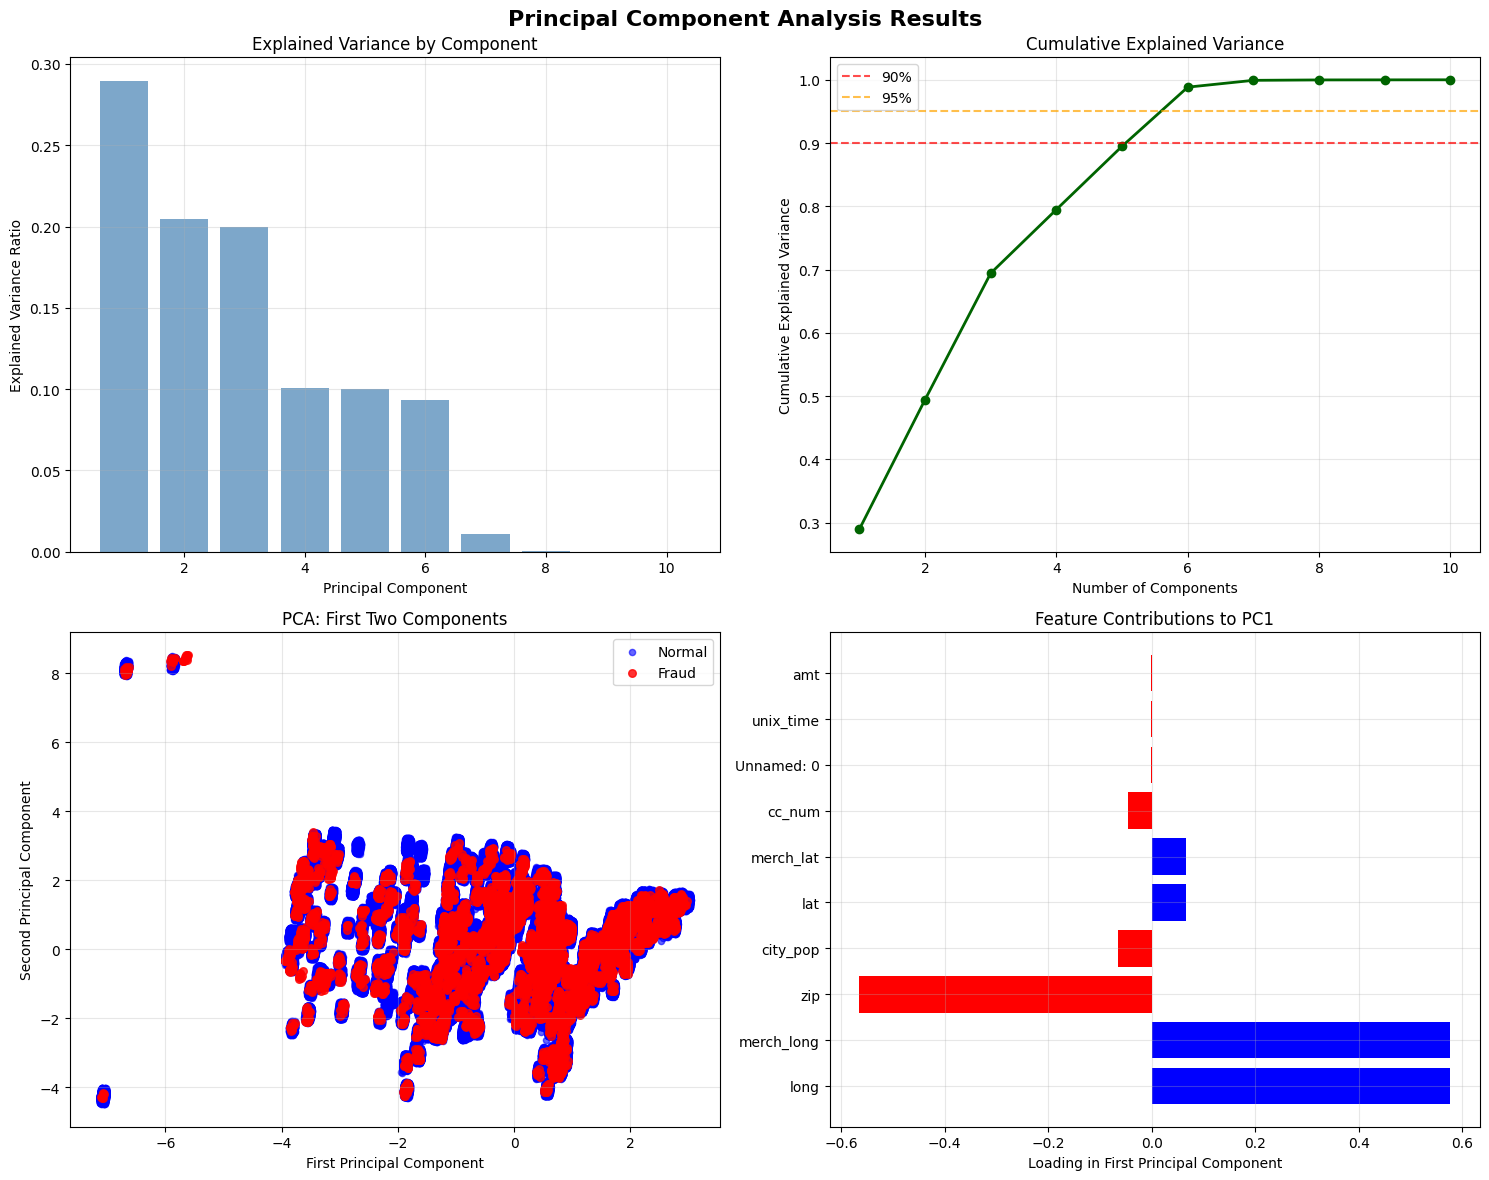

In [ ]:
def perform_dimensionality_reduction(df):
    """Perform PCA and other dimensionality reduction techniques"""
    print("DIMENSIONALITY REDUCTION")
    print("="*50)

    # Prepare features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'is_fraud' in numeric_cols:
        numeric_cols.remove('is_fraud')

    # Remove cluster columns added earlier
    numeric_cols = [col for col in numeric_cols if not col.startswith('cluster') and col != 'isolation_anomaly']

    if len(numeric_cols) < 3:
        print("Insufficient features for dimensionality reduction")
        return

    print(f"Using {len(numeric_cols)} features for PCA")

    # Prepare data
    X_pca = df[numeric_cols].fillna(df[numeric_cols].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)

    # Perform PCA
    pca = PCA()
    X_pca_transformed = pca.fit_transform(X_scaled)

    # Calculate cumulative explained variance
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
    n_components_90 = np.argmax(cumsum_var >= 0.90) + 1

    print(f" PCA Results:")
    print(f"   Components for 90% variance: {n_components_90}")
    print(f"   Components for 95% variance: {n_components_95}")
    print(f"   Original dimensions: {len(numeric_cols)}")
    print(f"   Dimensionality reduction: {len(numeric_cols) - n_components_95} components removed")

    # Apply PCA with optimal components
    pca_optimal = PCA(n_components=min(n_components_95, 10))  # Limit to 10 components max
    X_pca_reduced = pca_optimal.fit_transform(X_scaled)

    # Add PCA components to dataframe
    for i in range(pca_optimal.n_components_):
        df[f'pca_component_{i+1}'] = X_pca_reduced[:, i]

    # Visualize PCA results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Principal Component Analysis Results', fontsize=16, fontweight='bold')

    # Explained variance
    axes[0,0].bar(range(1, len(pca.explained_variance_ratio_) + 1),
                  pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
    axes[0,0].set_xlabel('Principal Component')
    axes[0,0].set_ylabel('Explained Variance Ratio')
    axes[0,0].set_title('Explained Variance by Component')
    axes[0,0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[0,1].plot(range(1, len(cumsum_var) + 1), cumsum_var,
                   marker='o', color='darkgreen', linewidth=2)
    axes[0,1].axhline(y=0.90, color='red', linestyle='--', alpha=0.7, label='90%')
    axes[0,1].axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    axes[0,1].set_title('Cumulative Explained Variance')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # First two principal components
    if 'is_fraud' in df.columns:
        fraud_mask = df['is_fraud'] == 1
        normal_mask = df['is_fraud'] == 0

        axes[1,0].scatter(X_pca_reduced[normal_mask, 0], X_pca_reduced[normal_mask, 1],
                         c='blue', alpha=0.6, s=20, label='Normal')
        axes[1,0].scatter(X_pca_reduced[fraud_mask, 0], X_pca_reduced[fraud_mask, 1],
                         c='red', alpha=0.8, s=30, label='Fraud')
        axes[1,0].set_xlabel('First Principal Component')
        axes[1,0].set_ylabel('Second Principal Component')
        axes[1,0].set_title('PCA: First Two Components')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

    # Feature importance in first PC
    feature_importance = pd.DataFrame({
        'feature': numeric_cols,
        'pc1_loading': pca_optimal.components_[0],
        'pc1_loading_abs': np.abs(pca_optimal.components_[0])
    }).sort_values('pc1_loading_abs', ascending=False)

    top_features = feature_importance.head(10)
    axes[1,1].barh(range(len(top_features)), top_features['pc1_loading'],
                   color=['red' if x < 0 else 'blue' for x in top_features['pc1_loading']])
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['feature'])
    axes[1,1].set_xlabel('Loading in First Principal Component')
    axes[1,1].set_title('Feature Contributions to PC1')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'n_components_90': n_components_90,
        'n_components_95': n_components_95,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'feature_importance': feature_importance
    }

# Run dimensionality reduction
pca_results = perform_dimensionality_reduction(df)


NETWORK ANALYSIS
Creating network from 1,000 transactions
Network Statistics:
   Nodes: 1,050
   Edges: 999
   Connected components: 91

 Most Central Nodes (Degree):
   Card_5790 (card): 0.0076
   Card_2074 (card): 0.0076
   fraud_Schuppe, Nolan and Hoeger (merchant): 0.0057
   Card_2684 (card): 0.0057
   Card_7244 (card): 0.0057

 Most Central Nodes (Betweenness):
   Card_3545 (card): 0.0916
   fraud_Berge LLC (merchant): 0.0879
   Card_2684 (card): 0.0787
   fraud_Padberg-Welch (merchant): 0.0766
   Card_9201 (card): 0.0721


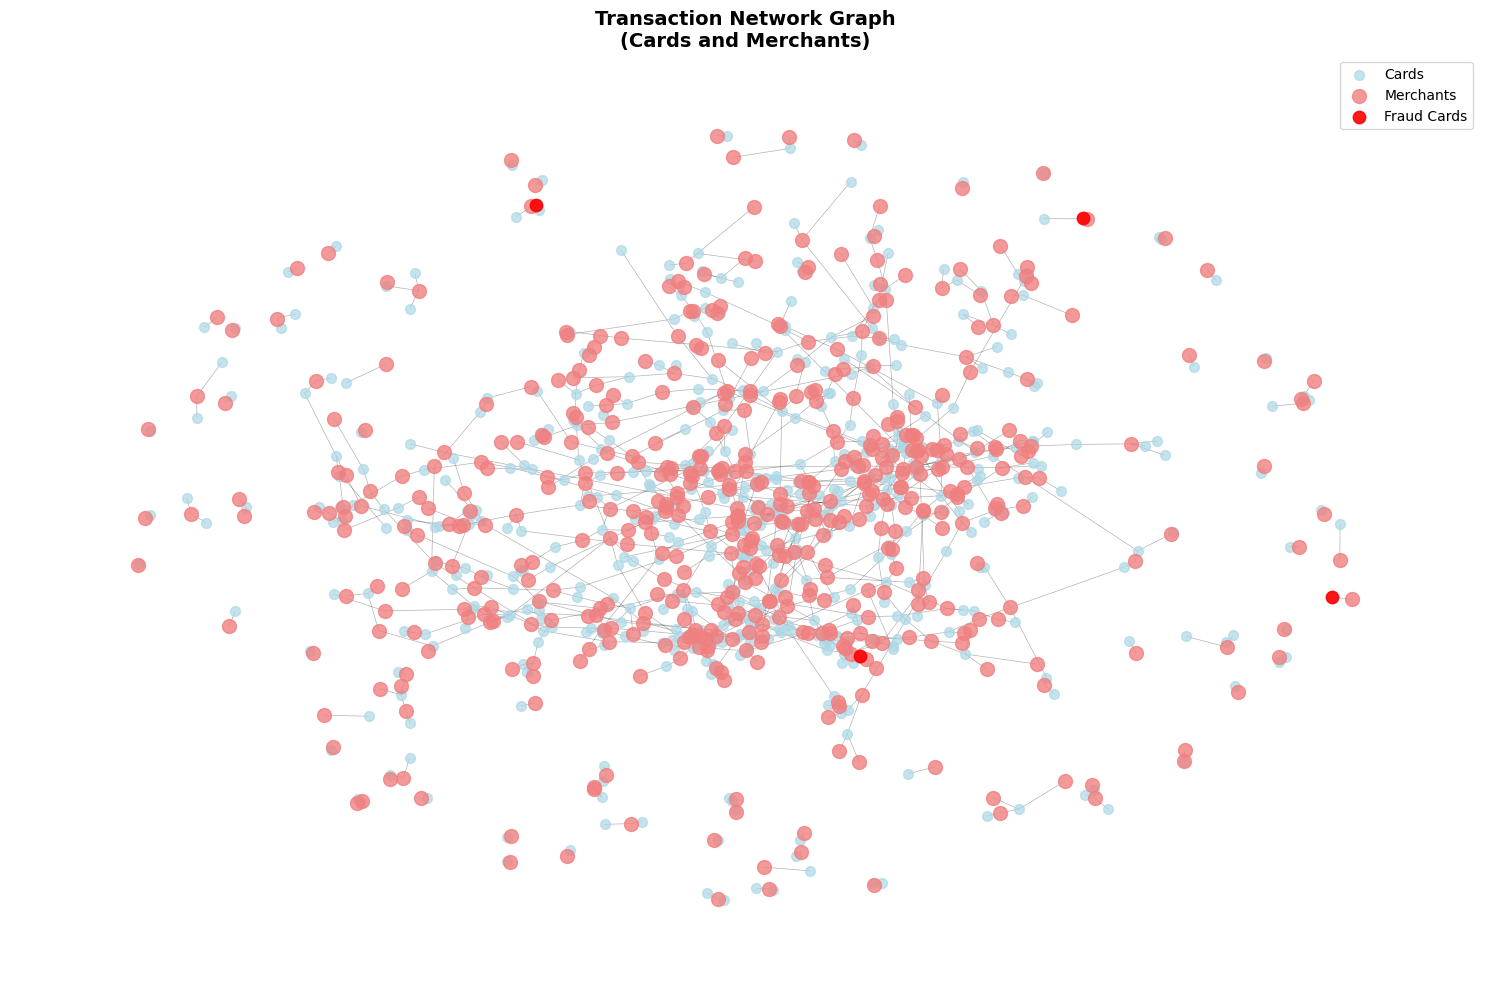


 Community Detection:
   Communities found: 114
   Community 1: 52 nodes
   Community 2: 52 nodes
   Community 3: 50 nodes
   Community 4: 40 nodes
   Community 5: 38 nodes


In [ ]:
def create_network_analysis(df):
    """Create and analyze transaction networks"""
    print("NETWORK ANALYSIS")
    print("="*50)

    # Create a simplified network based on available data
    # We'll create connections based on merchant, location, and user patterns

    if not all(col in df.columns for col in ['merchant', 'cc_num']):
        print("Required columns for network analysis not found")
        return

    # Sample data for network analysis (to keep it manageable)
    sample_size = min(1000, len(df))
    df_sample = df.sample(n=sample_size, random_state=CONFIG['random_state'])

    print(f"Creating network from {sample_size:,} transactions")

    # Create network graph
    G = nx.Graph()

    # Add nodes and edges based on card-merchant relationships
    for _, row in df_sample.iterrows():
        card = f"Card_{str(row['cc_num'])[-4:]}"  # Use last 4 digits for privacy
        merchant = row['merchant']

        # Add nodes
        G.add_node(card, type='card', fraud=row.get('is_fraud', 0))
        G.add_node(merchant, type='merchant')

        # Add edge
        weight = row.get('amt', 1)
        if G.has_edge(card, merchant):
            G[card][merchant]['weight'] += weight
            G[card][merchant]['transactions'] += 1
        else:
            G.add_edge(card, merchant, weight=weight, transactions=1)

    # Network statistics
    print(f"Network Statistics:")
    print(f"   Nodes: {G.number_of_nodes():,}")
    print(f"   Edges: {G.number_of_edges():,}")
    print(f"   Connected components: {nx.number_connected_components(G)}")

    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))

    # Find most central nodes
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"\n Most Central Nodes (Degree):")
    for node, centrality in top_degree:
        node_type = G.nodes[node].get('type', 'unknown')
        print(f"   {node} ({node_type}): {centrality:.4f}")

    print(f"\n Most Central Nodes (Betweenness):")
    for node, centrality in top_betweenness:
        node_type = G.nodes[node].get('type', 'unknown')
        print(f"   {node} ({node_type}): {centrality:.4f}")

    # Visualize network
    plt.figure(figsize=(15, 10))

    # Get positions using spring layout
    pos = nx.spring_layout(G, k=1, iterations=50, seed=CONFIG['random_state'])

    # Separate card and merchant nodes
    card_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'card']
    merchant_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'merchant']

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=card_nodes, node_color='lightblue',
                          node_size=50, alpha=0.7, label='Cards')
    nx.draw_networkx_nodes(G, pos, nodelist=merchant_nodes, node_color='lightcoral',
                          node_size=100, alpha=0.8, label='Merchants')

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

    # Highlight fraud connections if available
    if 'is_fraud' in df.columns:
        fraud_cards = [n for n, d in G.nodes(data=True)
                      if d.get('type') == 'card' and d.get('fraud', 0) == 1]
        if fraud_cards:
            nx.draw_networkx_nodes(G, pos, nodelist=fraud_cards, node_color='red',
                                  node_size=80, alpha=0.9, label='Fraud Cards')

    plt.title('Transaction Network Graph\n(Cards and Merchants)', fontsize=14, fontweight='bold')
    plt.legend(scatterpoints=1)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Community detection
    try:
        communities = list(nx.community.greedy_modularity_communities(G))
        print(f"\n Community Detection:")
        print(f"   Communities found: {len(communities)}")
        for i, community in enumerate(communities[:5]):  # Show first 5 communities
            print(f"   Community {i+1}: {len(community)} nodes")
    except:
        print("\n Community detection not available")

    return {
        'graph': G,
        'degree_centrality': degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'top_central_nodes': {
            'degree': top_degree,
            'betweenness': top_betweenness
        }
    }

# Run network analysis
network_results = create_network_analysis(df)

TEXT ANALYSIS
Text columns found: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']

 Analyzing column: merchant
   Unique values: 693
   Most common values:
     fraud_Kilback LLC: 4,403 (0.3%)
     fraud_Cormier LLC: 3,649 (0.3%)
     fraud_Schumm PLC: 3,634 (0.3%)
     fraud_Kuhn LLC: 3,510 (0.3%)
     fraud_Boyer PLC: 3,493 (0.3%)

 Analyzing column: category
   Unique values: 14
   Most common values:
     gas_transport: 131,659 (10.2%)
     grocery_pos: 123,638 (9.5%)
     home: 123,115 (9.5%)
     shopping_pos: 116,672 (9.0%)
     kids_pets: 113,035 (8.7%)
   Top 5 categories by fraud rate:
     shopping_net: 0.0176 (1713.0 frauds / 97543.0 total)
     misc_net: 0.0145 (915.0 frauds / 63287.0 total)
     grocery_pos: 0.0141 (1743.0 frauds / 123638.0 total)
     shopping_pos: 0.0072 (843.0 frauds / 116672.0 total)
     gas_transport: 0.0047 (618.0 frauds / 131659.0 total)

 Analyzing column: first
   Unique values: 352
   Mo

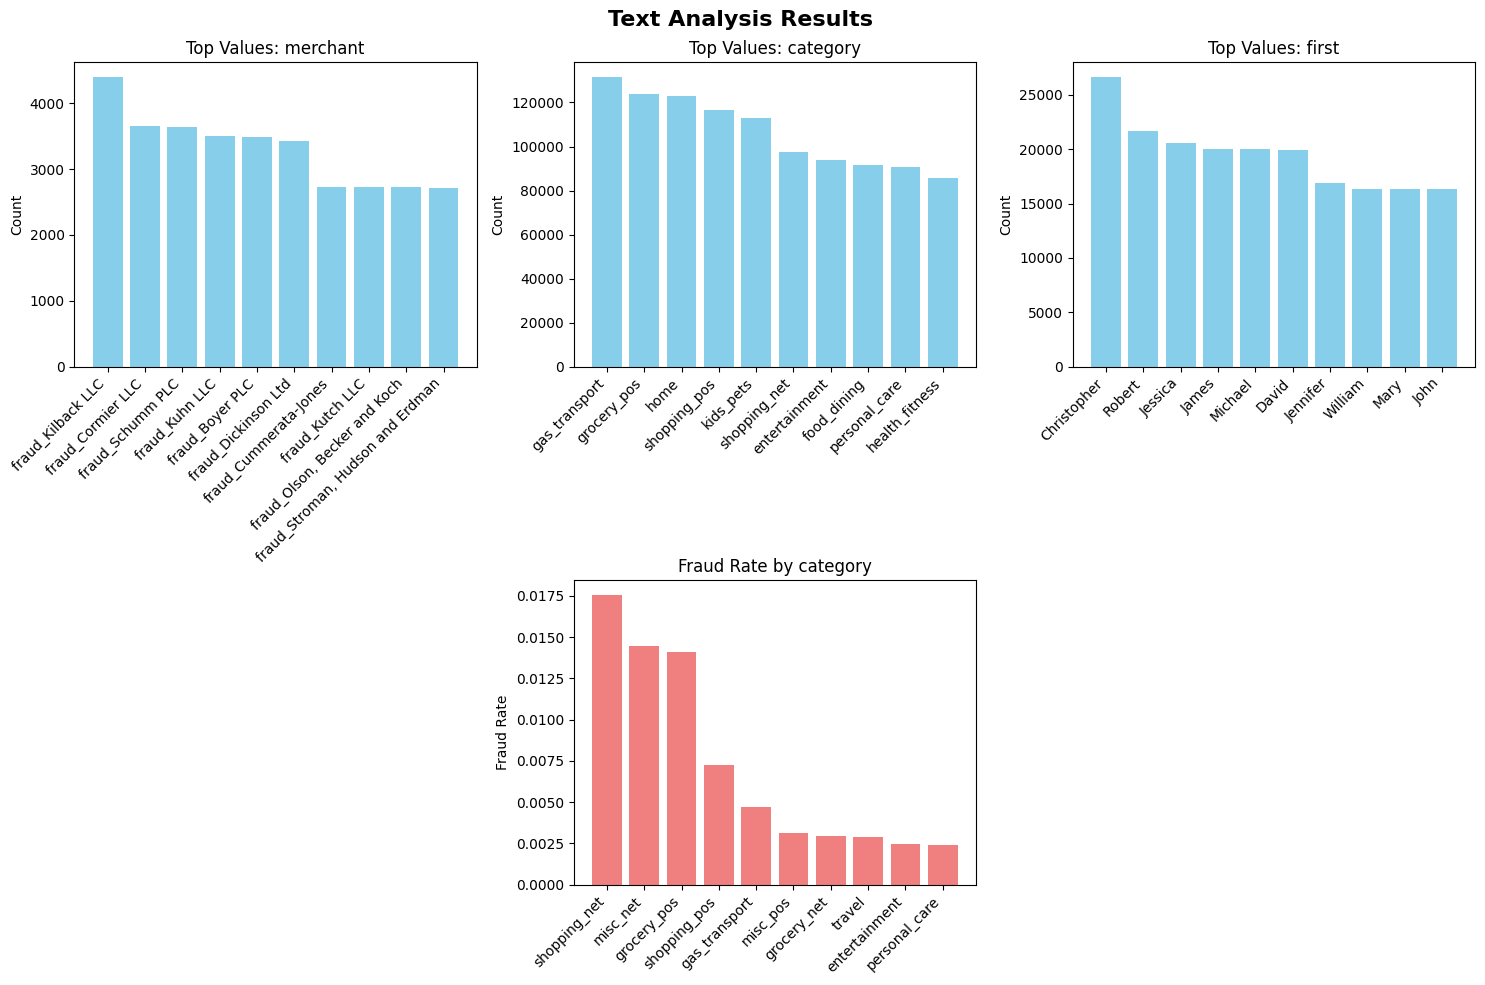

In [ ]:
def perform_text_analysis(df):
    """Perform text analysis on available text fields"""
    print("TEXT ANALYSIS")
    print("="*50)

    # Find text columns
    text_columns = []
    for col in df.columns:
        if df[col].dtype == 'object' and col not in ['trans_date_trans_time']:
            text_columns.append(col)

    if not text_columns:
        print("No text columns found for analysis")
        return

    print(f"Text columns found: {text_columns}")

    # Analyze categorical text columns
    text_analysis = {}

    for col in text_columns[:5]:  # Limit to first 5 columns
        print(f"\n Analyzing column: {col}")

        # Basic statistics
        unique_count = df[col].nunique()
        most_common = df[col].value_counts().head(5)

        print(f"   Unique values: {unique_count:,}")
        print(f"   Most common values:")
        for value, count in most_common.items():
            print(f"     {value}: {count:,} ({count/len(df)*100:.1f}%)")

        text_analysis[col] = {
            'unique_count': unique_count,
            'most_common': most_common.to_dict()
        }

        # Analyze relationship with fraud if available
        if 'is_fraud' in df.columns and unique_count < 50:  # Only for categorical data
            fraud_by_category = df.groupby(col)['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
            fraud_by_category['fraud_rate'] = fraud_by_category['mean']
            fraud_by_category = fraud_by_category.sort_values('fraud_rate', ascending=False)

            print(f"   Top 5 categories by fraud rate:")
            for idx, row in fraud_by_category.head(5).iterrows():
                print(f"     {idx}: {row['fraud_rate']:.4f} ({row['sum']} frauds / {row['count']} total)")

            text_analysis[col]['fraud_analysis'] = fraud_by_category.to_dict()

    # Create visualizations for text analysis
    if text_columns:
        n_cols = min(3, len(text_columns))
        fig, axes = plt.subplots(2, n_cols, figsize=(5*n_cols, 10))
        if n_cols == 1:
            axes = axes.reshape(-1, 1)
        fig.suptitle('Text Analysis Results', fontsize=16, fontweight='bold')

        for i, col in enumerate(text_columns[:n_cols]):
            # Value counts
            top_values = df[col].value_counts().head(10)
            axes[0, i].bar(range(len(top_values)), top_values.values, color='skyblue')
            axes[0, i].set_title(f'Top Values: {col}')
            axes[0, i].set_xticks(range(len(top_values)))
            axes[0, i].set_xticklabels(top_values.index, rotation=45, ha='right')
            axes[0, i].set_ylabel('Count')

            # Fraud rate by category (if applicable)
            if 'is_fraud' in df.columns and df[col].nunique() < 20:
                fraud_rates = df.groupby(col)['is_fraud'].mean().sort_values(ascending=False).head(10)
                axes[1, i].bar(range(len(fraud_rates)), fraud_rates.values, color='lightcoral')
                axes[1, i].set_title(f'Fraud Rate by {col}')
                axes[1, i].set_xticks(range(len(fraud_rates)))
                axes[1, i].set_xticklabels(fraud_rates.index, rotation=45, ha='right')
                axes[1, i].set_ylabel('Fraud Rate')
            else:
                fig.delaxes(axes[1, i])

        plt.tight_layout()
        plt.show()

    return text_analysis

# Run text analysis
text_results = perform_text_analysis(df)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

MACHINE LEARNING MODELS (GPU-Accelerated)
Using device: cuda
GPU: Tesla T4
Loaded test data from /content/drive/My Drive/Colab Notebooks/fraudTest.csv: (555719, 23)
Features selected:
   Numeric: 8 features
   Categorical: 5 features
Training data shape: (1296675, 13)
Test data shape: (555719, 13)
Training target distribution: {0: 1289169, 1: 7506}
Test target distribution: {0: 553574, 1: 2145}

Training Models:
------------------------------

Training Logistic Regression...
    AUC Score: 0.8241
    F1 Score: 0.0000
    CV AUC: 0.8295 (±0.0122)

Training Random Forest...
    AUC Score: 0.9442
    F1 Score: 0.6048
    CV AUC: 0.7851 (±0.1644)

Training Neural Network (sklearn)...
    AUC Score: 0.9870
    F1 Score: 0.6717
    CV AUC: 0.9699 (±0.0222)

Training PyTorch Neural Net (GPU)...
    Epoch 20/100, Loss: 0.0119
    Epoch 40/100, Loss: 0.0112
    Epoch 60/100, Loss: 0.0110
    Epoch 80/100, Loss: 0.0108
    Epoch 100/100, Loss: 0.0107
    AUC Score: 0.9864
    F1 Score: 0.6738

M

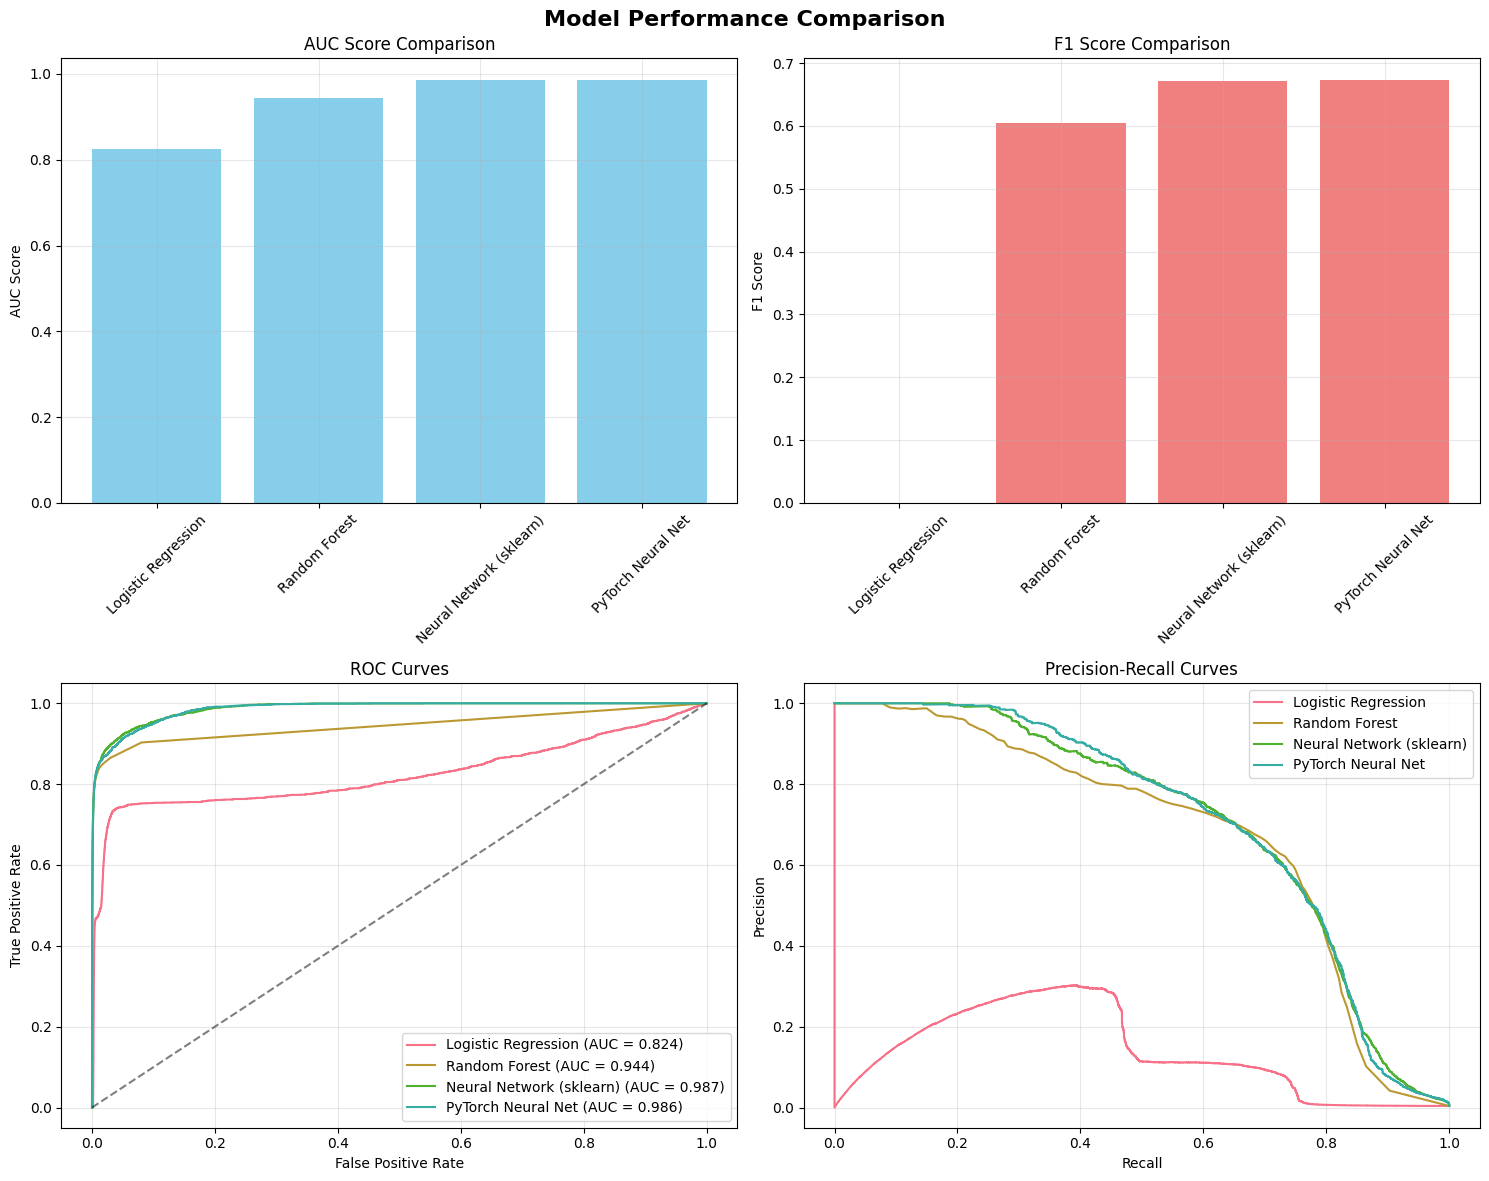

In [ ]:
def build_ml_models(df, test_csv_path='fraudTest.csv'):
    """Build and evaluate machine learning models for fraud detection using GPU acceleration"""
    print("MACHINE LEARNING MODELS (GPU-Accelerated)")
    print("="*50)

    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    if 'is_fraud' not in df.columns:
        print("No fraud target variable found")
        return

    # Load test data from CSV
    try:
        test_df = pd.read_csv(test_csv_path)
        print(f"Loaded test data from {test_csv_path}: {test_df.shape}")
    except FileNotFoundError:
        print(f"Test file {test_csv_path} not found. Please ensure the file exists.")
        return
    except Exception as e:
        print(f"Error loading test data: {e}")
        return

    # Prepare features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = ['merchant', 'category', 'gender', 'state', 'job']

    # Remove target and unnecessary columns
    exclude_cols = ['is_fraud', 'trans_date_trans_time', 'cc_num', 'trans_num',
                   'first', 'last', 'street', 'dob', 'unix_time']
    numeric_features = [col for col in numeric_features if col not in exclude_cols]
    categorical_features = [col for col in categorical_features if col in df.columns and col in test_df.columns]

    print(f"Features selected:")
    print(f"   Numeric: {len(numeric_features)} features")
    print(f"   Categorical: {len(categorical_features)} features")

    # Prepare training data
    X_train_numeric = df[numeric_features].fillna(df[numeric_features].median())
    X_train_categorical = pd.DataFrame()

    # Store label encoders for consistent encoding
    label_encoders = {}

    for col in categorical_features:
        if col in df.columns:
            le = LabelEncoder()
            # Fit on combined train and test data to ensure consistent encoding
            combined_values = pd.concat([df[col].astype(str), test_df[col].astype(str)]).unique()
            le.fit(combined_values)
            label_encoders[col] = le
            X_train_categorical[col] = le.transform(df[col].astype(str))

    # Combine training features
    X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
    y_train = df['is_fraud']

    # Prepare test data
    X_test_numeric = test_df[numeric_features].fillna(df[numeric_features].median())  # Use train medians
    X_test_categorical = pd.DataFrame()

    for col in categorical_features:
        if col in test_df.columns:
            X_test_categorical[col] = label_encoders[col].transform(test_df[col].astype(str))

    # Combine test features
    X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)
    y_test = test_df['is_fraud'] if 'is_fraud' in test_df.columns else None

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Training target distribution: {y_train.value_counts().to_dict()}")

    if y_test is not None:
        print(f"Test target distribution: {y_test.value_counts().to_dict()}")
    else:
        print("No target variable found in test data - will generate predictions only")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PyTorch Neural Network Class
    class FraudNet(nn.Module):
        def __init__(self, input_size):
            super(FraudNet, self).__init__()
            self.fc1 = nn.Linear(input_size, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 32)
            self.fc4 = nn.Linear(32, 1)
            self.dropout = nn.Dropout(0.3)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.relu(self.fc3(x))
            x = self.sigmoid(self.fc4(x))
            return x

    # Initialize models (GPU-enabled where possible)
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
        'Neural Network (sklearn)': MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100, 50))
    }

    # Add PyTorch model if we have target data for evaluation
    if y_test is not None:
        models['PyTorch Neural Net'] = None  # Will be handled separately

    model_results = {}

    print(f"\nTraining Models:")
    print("-" * 30)

    for name, model in models.items():
        if name == 'PyTorch Neural Net':
            continue  # Handle separately

        print(f"\nTraining {name}...")

        # Use scaled data for models that benefit from it
        if name in ['Logistic Regression', 'Neural Network (sklearn)']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test

        # Train model
        model.fit(X_train_model, y_train)

        # Predictions
        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]

        # Evaluate only if we have test targets
        if y_test is not None:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred)

            # Cross-validation on training data
            cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='roc_auc')

            model_results[name] = {
                'model': model,
                'auc_score': auc_score,
                'f1_score': f1,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            print(f"    AUC Score: {auc_score:.4f}")
            print(f"    F1 Score: {f1:.4f}")
            print(f"    CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        else:
            model_results[name] = {
                'model': model,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            print(f"    Predictions generated (no evaluation metrics - missing target)")

    # Train PyTorch model if we have test targets
    if y_test is not None and 'PyTorch Neural Net' in models:
        print(f"\nTraining PyTorch Neural Net (GPU)...")

        # Prepare data for PyTorch
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
        y_train_tensor = torch.FloatTensor(y_train.values).to(device)
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

        # Create model
        pytorch_model = FraudNet(X_train_scaled.shape[1]).to(device)

        # Loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

        # Training
        batch_size = 1024
        n_epochs = 100

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        pytorch_model.train()
        for epoch in range(n_epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = pytorch_model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if (epoch + 1) % 20 == 0:
                print(f"    Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader):.4f}")

        # Predictions
        pytorch_model.eval()
        with torch.no_grad():
            y_pred_proba_torch = pytorch_model(X_test_tensor).squeeze().cpu().numpy()
            y_pred_torch = (y_pred_proba_torch > 0.5).astype(int)

        # Evaluate
        auc_score = roc_auc_score(y_test, y_pred_proba_torch)
        f1 = f1_score(y_test, y_pred_torch)

        model_results['PyTorch Neural Net'] = {
            'model': pytorch_model,
            'auc_score': auc_score,
            'f1_score': f1,
            'cv_mean': np.nan,  # CV not implemented for PyTorch model
            'cv_std': np.nan,
            'y_pred': y_pred_torch,
            'y_pred_proba': y_pred_proba_torch
        }

        print(f"    AUC Score: {auc_score:.4f}")
        print(f"    F1 Score: {f1:.4f}")

    # Model comparison (only if we have evaluation metrics)
    if y_test is not None and any('auc_score' in results for results in model_results.values()):
        print(f"\nMODEL COMPARISON:")
        print("-" * 50)

        comparison_data = []
        for name, results in model_results.items():
            if 'auc_score' in results:
                comparison_data.append({
                    'Model': name,
                    'AUC Score': results['auc_score'],
                    'F1 Score': results['f1_score'],
                    'CV Mean': results.get('cv_mean', np.nan),
                    'CV Std': results.get('cv_std', np.nan)
                })

        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.round(4))

        # Visualizations (only if we have metrics to compare)
        if len(comparison_data) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

            # AUC comparison
            axes[0,0].bar(comparison_df['Model'], comparison_df['AUC Score'], color='skyblue')
            axes[0,0].set_title('AUC Score Comparison')
            axes[0,0].set_ylabel('AUC Score')
            axes[0,0].tick_params(axis='x', rotation=45)
            axes[0,0].grid(True, alpha=0.3)

            # F1 comparison
            axes[0,1].bar(comparison_df['Model'], comparison_df['F1 Score'], color='lightcoral')
            axes[0,1].set_title('F1 Score Comparison')
            axes[0,1].set_ylabel('F1 Score')
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)

            # ROC Curves
            for name, results in model_results.items():
                if 'auc_score' in results:
                    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
                    axes[1,0].plot(fpr, tpr, label=f"{name} (AUC = {results['auc_score']:.3f})")

            axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[1,0].set_xlabel('False Positive Rate')
            axes[1,0].set_ylabel('True Positive Rate')
            axes[1,0].set_title('ROC Curves')
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3)

            # Precision-Recall Curves
            for name, results in model_results.items():
                if 'auc_score' in results:
                    precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
                    axes[1,1].plot(recall, precision, label=f"{name}")

            axes[1,1].set_xlabel('Recall')
            axes[1,1].set_ylabel('Precision')
            axes[1,1].set_title('Precision-Recall Curves')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            return model_results, comparison_df
    else:
        print(f"\nPredictions generated for all models. No evaluation metrics available without test targets.")
        return model_results, None

ml_results, model_comparison = build_ml_models(df, test_csv_path='/content/drive/My Drive/Colab Notebooks/fraudTest.csv')

TEMPORAL ANALYSIS
Date columns found: ['trans_date_trans_time', 'unix_time']
Converted trans_date_trans_time to datetime
Converted unix_time to datetime
Using trans_date_trans_time for temporal analysis

 Temporal Statistics:
   Date range: 2019-01-01 00:00:18 to 2020-06-21 12:13:37
   Total days: 537
   Records per day (avg): 2410.2

 Peak Activity:
   Peak hour: 23:00 (67,104 transactions)
   Peak day: Monday (254,282 transactions)
   Peak month: May (146,875 transactions)

 Fraud Temporal Patterns:
   Highest fraud rate hour: 22:00 (0.0288)
   Highest fraud rate day: Friday (0.0071)
   Highest fraud rate month: February (0.0087)


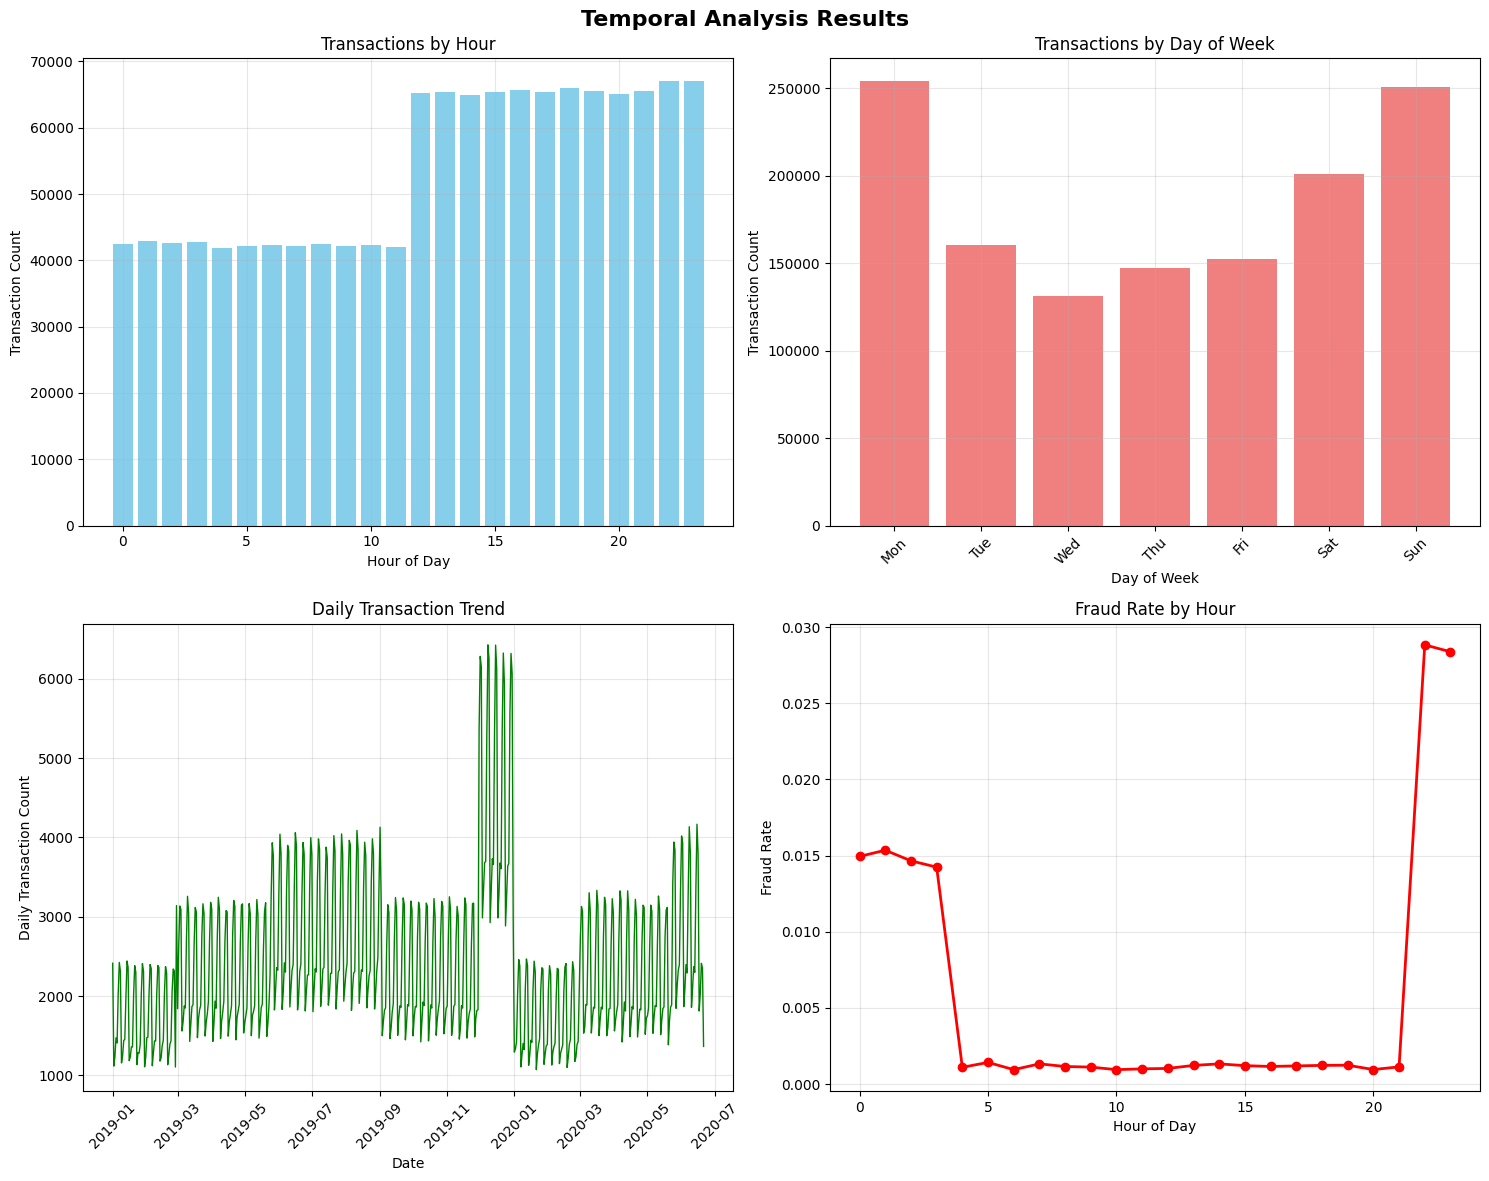

In [ ]:
def perform_temporal_analysis(df):
    """Analyze temporal patterns in the data"""
    print("TEMPORAL ANALYSIS")
    print("="*50)

    # Find date columns
    date_columns = []
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            date_columns.append(col)

    if not date_columns:
        print("No date/time columns found")
        return

    print(f"Date columns found: {date_columns}")

    # Convert date columns to datetime
    for col in date_columns:
        try:
            df[col] = pd.to_datetime(df[col])
            print(f"Converted {col} to datetime")
        except:
            print(f"Could not convert {col} to datetime")
            continue

    # Use the first valid date column
    date_col = None
    for col in date_columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            date_col = col
            break

    if date_col is None:
        print("No valid datetime columns found")
        return

    print(f"Using {date_col} for temporal analysis")

    # Extract temporal features
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['hour'] = df[date_col].dt.hour
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['day_name'] = df[date_col].dt.day_name()
    df['month_name'] = df[date_col].dt.month_name()

    # Basic temporal statistics
    print(f"\n Temporal Statistics:")
    print(f"   Date range: {df[date_col].min()} to {df[date_col].max()}")
    print(f"   Total days: {(df[date_col].max() - df[date_col].min()).days}")
    print(f"   Records per day (avg): {len(df) / ((df[date_col].max() - df[date_col].min()).days + 1):.1f}")

    # Analyze patterns
    temporal_patterns = {}

    # Hourly patterns
    hourly_counts = df.groupby('hour').size()
    temporal_patterns['hourly'] = hourly_counts.to_dict()

    # Daily patterns
    daily_counts = df.groupby('day_name').size()
    temporal_patterns['daily'] = daily_counts.to_dict()

    # Monthly patterns
    monthly_counts = df.groupby('month_name').size()
    temporal_patterns['monthly'] = monthly_counts.to_dict()

    print(f"\n Peak Activity:")
    print(f"   Peak hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} transactions)")
    print(f"   Peak day: {daily_counts.idxmax()} ({daily_counts.max():,} transactions)")
    print(f"   Peak month: {monthly_counts.idxmax()} ({monthly_counts.max():,} transactions)")

    # Fraud patterns over time (if available)
    if 'is_fraud' in df.columns:
        print(f"\n Fraud Temporal Patterns:")

        fraud_by_hour = df.groupby('hour')['is_fraud'].agg(['count', 'sum', 'mean'])
        fraud_by_day = df.groupby('day_name')['is_fraud'].agg(['count', 'sum', 'mean'])
        fraud_by_month = df.groupby('month_name')['is_fraud'].agg(['count', 'sum', 'mean'])

        print(f"   Highest fraud rate hour: {fraud_by_hour['mean'].idxmax()}:00 ({fraud_by_hour['mean'].max():.4f})")
        print(f"   Highest fraud rate day: {fraud_by_day['mean'].idxmax()} ({fraud_by_day['mean'].max():.4f})")
        print(f"   Highest fraud rate month: {fraud_by_month['mean'].idxmax()} ({fraud_by_month['mean'].max():.4f})")

    # Visualize temporal patterns
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Temporal Analysis Results', fontsize=16, fontweight='bold')

    # Hourly pattern
    axes[0,0].bar(hourly_counts.index, hourly_counts.values, color='skyblue')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Transaction Count')
    axes[0,0].set_title('Transactions by Hour')
    axes[0,0].grid(True, alpha=0.3)

    # Daily pattern
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_ordered = daily_counts.reindex(day_order)
    axes[0,1].bar(range(len(daily_ordered)), daily_ordered.values, color='lightcoral')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Transaction Count')
    axes[0,1].set_title('Transactions by Day of Week')
    axes[0,1].set_xticks(range(len(daily_ordered)))
    axes[0,1].set_xticklabels([d[:3] for d in daily_ordered.index], rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # Time series plot
    daily_trend = df.groupby(df[date_col].dt.date).size()
    axes[1,0].plot(daily_trend.index, daily_trend.values, color='green', linewidth=1)
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Daily Transaction Count')
    axes[1,0].set_title('Daily Transaction Trend')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)

    # Fraud rate by hour (if available)
    if 'is_fraud' in df.columns:
        fraud_rates = df.groupby('hour')['is_fraud'].mean()
        axes[1,1].plot(fraud_rates.index, fraud_rates.values, marker='o', color='red', linewidth=2)
        axes[1,1].set_xlabel('Hour of Day')
        axes[1,1].set_ylabel('Fraud Rate')
        axes[1,1].set_title('Fraud Rate by Hour')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'No fraud data\navailable',
                       ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Fraud Analysis Not Available')

    plt.tight_layout()
    plt.show()

    return temporal_patterns

# Run temporal analysis
temporal_results = perform_temporal_analysis(df)
